# Customer Churn Prediction with XGBoost
_**Using Gradient Boosted Trees to Predict Mobile Customer Departure**_

---

---

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host-The-Model)
  1. [Evaluate](#Evaluate)
1. [Extensions](#Extensions)

---

## Background

_This notebook has been adapted from an [AWS blog post](https://aws.amazon.com/blogs/ai/predicting-customer-churn-with-amazon-machine-learning/)_

Losing customers is costly for any business.  Identifying unhappy customers early on gives you a chance to offer them incentives to stay.  This notebook describes using machine learning (ML) for the automated identification of unhappy customers, also known as customer churn prediction. ML models rarely give perfect predictions though, so this notebook is also about how to incorporate the relative costs of prediction mistakes when determining the financial outcome of using ML.

We use an example of churn that is familiar to all of us–leaving a mobile phone operator.  Seems like I can always find fault with my provider du jour! And if my provider knows that I’m thinking of leaving, it can offer timely incentives–I can always use a phone upgrade or perhaps have a new feature activated–and I might just stick around. Incentives are often much more cost effective than losing and reacquiring a customer.

---

## Setup

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Run the below cell to Specify:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting. In this case we'll use Sagemaker's default bucket.
- The IAM role arn used to give training and hosting access to your data.

In [2]:
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role
import sagemaker

role = get_execution_role()
session = sagemaker.Session()
bucket = session.default_bucket()
prefix = 'sagemaker/DEMO-xgboost-churn'
print(f'Using bucket: {bucket}')

Using bucket: sagemaker-us-west-2-240759585283


Next, we'll import the Python libraries we'll need for the remainder of the exercise.
In particular note:
1. [Pandas](https://pandas.pydata.org/) - A Python library for data manipulation and analysis. In particular, it offers data structures and operations for manipulating numerical tables and time series.
2. [Numpy](http://www.numpy.org/) - A Python library that adds support for large, multi-dimensional arrays and matrices.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display
import sagemaker

---
## Data

Mobile operators have historical records on which customers ultimately ended up churning and which continued using the service. We can use this historical information to construct an ML model of one mobile operator’s churn using a process called training. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model, and have the model predict whether this customer is going to churn. Of course, we expect the model to make mistakes–after all, predicting the future is tricky business! But I’ll also show how to deal with prediction errors.

The dataset we use is publicly available and was mentioned in the book [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets.  Let's download and read that dataset in now:

In [4]:
!wget http://dataminingconsultant.com/DKD2e_data_sets.zip
!unzip -o DKD2e_data_sets.zip
!ls -l 'Data sets/churn.txt'

--2018-10-15 12:35:10--  http://dataminingconsultant.com/DKD2e_data_sets.zip
Resolving dataminingconsultant.com (dataminingconsultant.com)... 160.153.91.162
Connecting to dataminingconsultant.com (dataminingconsultant.com)|160.153.91.162|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1003616 (980K) [application/zip]
Saving to: ‘DKD2e_data_sets.zip’

DKD2e_data_sets.zip 100%[===================>] 980.09K  2.67MB/s    in 0.4s    

2018-10-15 12:35:11 (2.67 MB/s) - ‘DKD2e_data_sets.zip’ saved [1003616/1003616]

Archive:  DKD2e_data_sets.zip
 extracting: Data sets/adult.zip     
  inflating: Data sets/cars.txt      
  inflating: Data sets/cars2.txt     
  inflating: Data sets/cereals.CSV   
  inflating: Data sets/churn.txt     
  inflating: Data sets/ClassifyRisk  
  inflating: Data sets/ClassifyRisk - Missing.txt  
 extracting: Data sets/DKD2e data sets.zip  
  inflating: Data sets/nn1.txt       
-rw-rw-r-- 1 ec2-user ec2-user 437903 Jun 11  2017 Data sets/churn.

---
Load into a Pandas Dataframe:  
churn.txt is a CSV file, load it into a Pandas Dataframe by using the relevant [Pandas method for reading input](https://pandas.pydata.org/pandas-docs/stable/api.html).

### Update the code cell

In [6]:
churn = pd.read_csv('./Data sets/churn.txt') # Use pandas to read in CSV format
pd.set_option('display.max_columns', 500)
churn.head(5) # Print first five records

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


By modern standards, it’s a relatively small dataset, with only 3,333 records, where each record uses 21 attributes to describe the profile of a customer of an unknown US mobile operator. The attributes are:

- `State`: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ
- `Account Length`: the number of days that this account has been active
- `Area Code`: the three-digit area code of the corresponding customer’s phone number
- `Phone`: the remaining seven-digit phone number
- `Int’l Plan`: whether the customer has an international calling plan: yes/no
- `VMail Plan`: whether the customer has a voice mail feature: yes/no
- `VMail Message`: presumably the average number of voice mail messages per month
- `Day Mins`: the total number of calling minutes used during the day
- `Day Calls`: the total number of calls placed during the day
- `Day Charge`: the billed cost of daytime calls
- `Eve Mins, Eve Calls, Eve Charge`: the billed cost for calls placed during the evening
- `Night Mins`, `Night Calls`, `Night Charge`: the billed cost for calls placed during nighttime
- `Intl Mins`, `Intl Calls`, `Intl Charge`: the billed cost for international calls
- `CustServ Calls`: the number of calls placed to Customer Service
- `Churn?`: whether the customer left the service: true/false

The last attribute, `Churn?`, is known as the target attribute–the attribute that we want the ML model to predict.  Because the target attribute is binary, our model will be performing binary prediction, also known as binary classification.

---
As Data scientists, before plugging our data into an ML algorithm, we must first explore our data to understand:
1. Which features are categorical and which are numeric. Which features categorical Numpy wrongly classified as numeric.
2. Each feature values distribution and cardinality.
3. Which features we should drop from the dataset because we can easily see they would not contribute to the model, or because they are highly correlated with other features.

You should really explore all features, but in this notebook, we decided to focus on specific features we know are interesting.  
Let's start exploring:

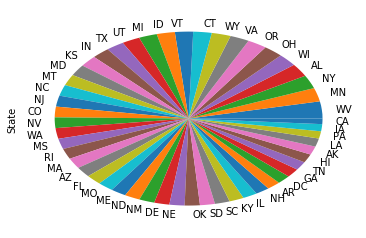

In [8]:
churn.State.value_counts(sort=True).plot.pie()
plt.show()

Note `State` appears to be quite evenly distributed

In [9]:
def crosstab(column):
    display(pd.crosstab(index=churn[column], columns='% observations', normalize='columns'))
crosstab('Phone')

col_0,% observations
Phone,
327-1058,0.0003
327-1319,0.0003
327-3053,0.0003
327-3587,0.0003
327-3850,0.0003
327-3954,0.0003
327-4795,0.0003
327-5525,0.0003
327-5817,0.0003


`Phone` takes on too many unique values to be of any practical use. It's possible parsing out the prefix could have some value, but without more context on how these are allocated, we should avoid using it.  
Let's drop the `Phone` column:

In [10]:
churn = churn.drop('Phone', axis=1)

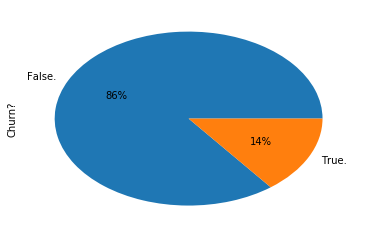

In [11]:
churn['Churn?'].value_counts(sort=True).plot.pie(autopct='%1.f%%')
plt.show()

We can see only 14% of customers churned, so there is some class imabalance, but nothing extreme.

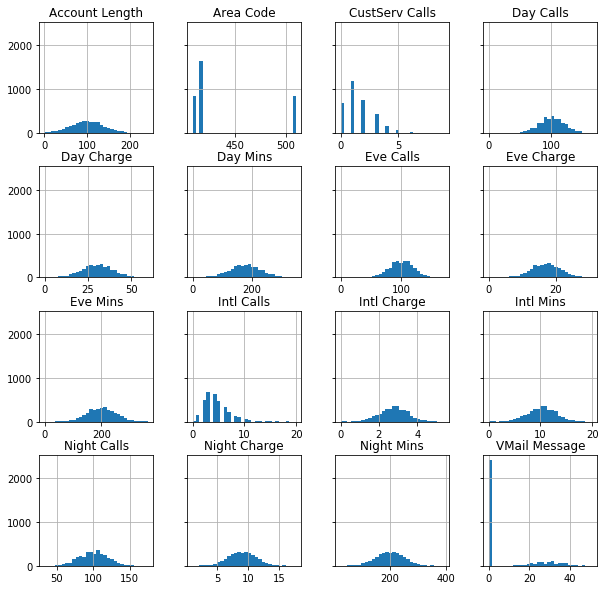

In [12]:
# Histograms for each numeric features
#display(churn.describe())
%matplotlib inline
hist = churn.hist(bins=30, sharey=True, figsize=(10, 10))

Most of the numeric features are surprisingly nicely distributed, with many showing bell-like gaussianity.  `VMail Message` being a notable exception (and `Area Code` showing up as a feature we should convert to non-numeric).  
Let's convert `Area Code` to non-numeric:

In [13]:
churn['Area Code'] = churn['Area Code'].astype(object)

Next let's look at the relationship between each of the features and our target variable.

Churn?,False.,True.
State,,
AK,0.017193,0.006211
AL,0.025263,0.016563
AR,0.015439,0.022774
AZ,0.021053,0.008282
CA,0.008772,0.018634
CO,0.020000,0.018634
CT,0.021754,0.024845
DC,0.017193,0.010352
DE,0.018246,0.018634


Churn?,False.,True.
Area Code,,
408,0.251228,0.252588
415,0.497895,0.488613
510,0.250877,0.258799


Churn?,False.,True.
Int'l Plan,,
no,0.934737,0.716356
yes,0.065263,0.283644


Churn?,False.,True.
VMail Plan,,
no,0.704561,0.834369
yes,0.295439,0.165631


Account Length


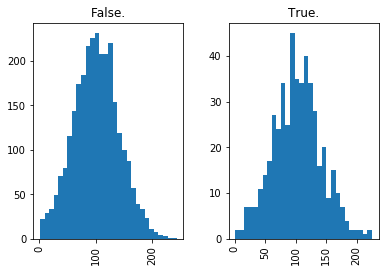

VMail Message


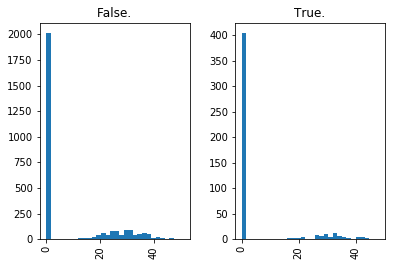

Day Mins


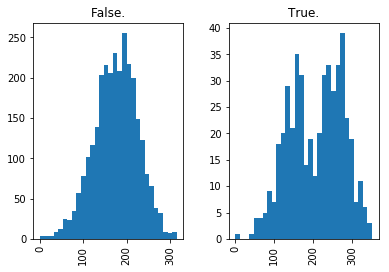

Day Calls


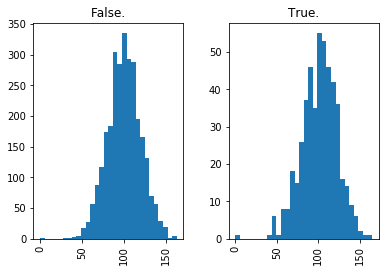

Day Charge


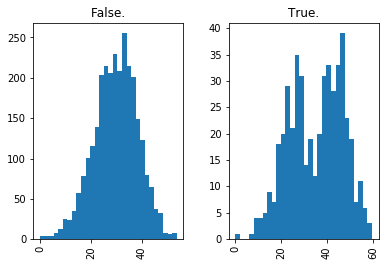

Eve Mins


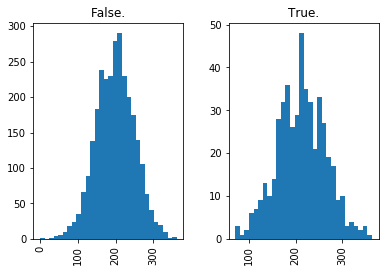

Eve Calls


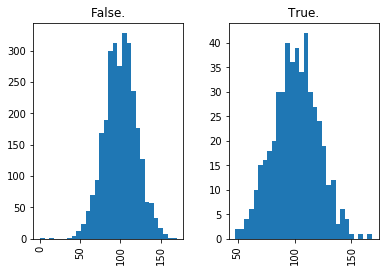

Eve Charge


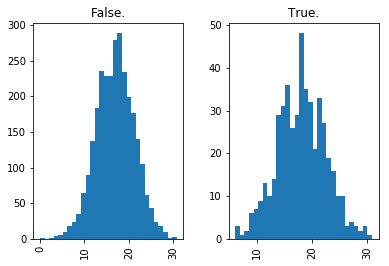

Night Mins


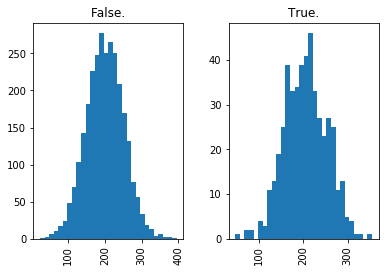

Night Calls


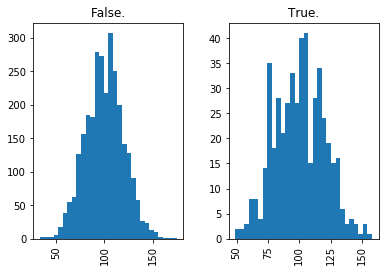

Night Charge


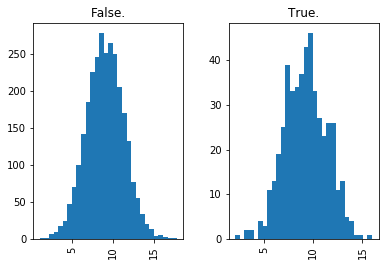

Intl Mins


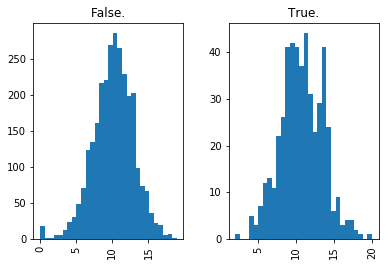

Intl Calls


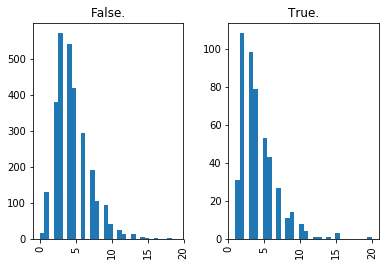

Intl Charge


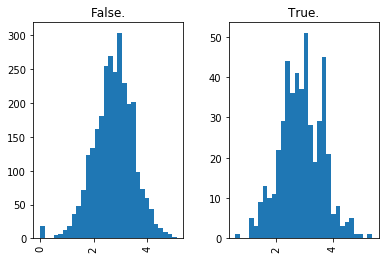

CustServ Calls


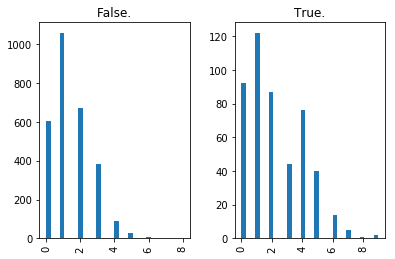

In [14]:
for column in churn.select_dtypes(include=['object']).columns:
    if column != 'Churn?':
        display(pd.crosstab(index=churn[column], columns=churn['Churn?'], normalize='columns'))

for column in churn.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = churn[[column, 'Churn?']].hist(by='Churn?', bins=30)
    plt.show()

Interestingly we see that churners appear:
- Fairly evenly distributed geographically
- More likely to have an international plan
- Less likely to have a voicemail plan
- To exhibit some bimodality in daily minutes (either higher or lower than the average for non-churners)
- To have a larger number of customer service calls (which makes sense as we'd expect customers who experience lots of problems may be more likely to churn)

In addition, we see that churners take on very similar distributions for features like `Day Mins` and `Day Charge`.  That's not surprising as we'd expect minutes spent talking to correlate with charges.  Let's dig deeper into the relationships between our features.

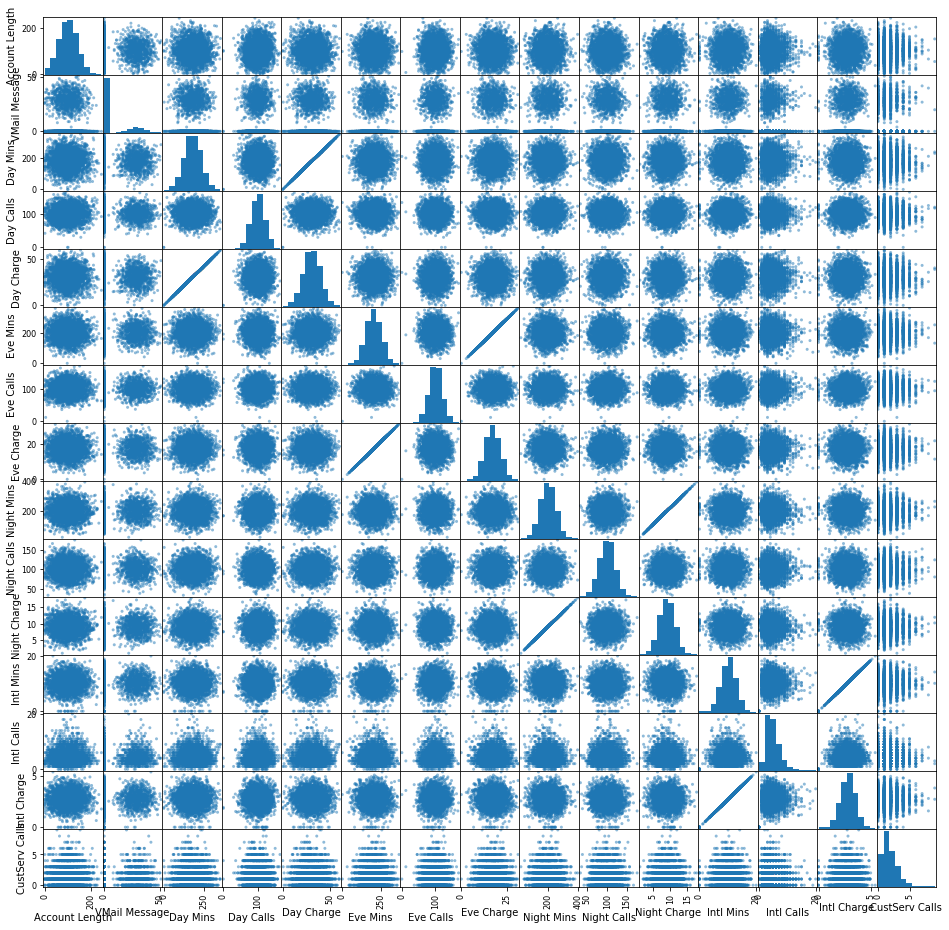

In [17]:
# Show the correlation between each possible features pair as a scatter plot
pd.plotting.scatter_matrix(churn, figsize=(16, 16))
plt.show()

We see several features that essentially have 100% correlation with one another.  Including these feature pairs in some machine learning algorithms can create catastrophic problems, while in others it will only introduce minor redundancy and bias.  Let's remove one feature from each of the highly correlated pairs: Day Charge from the pair with Day Mins, Night Charge from the pair with Night Mins, Intl Charge from the pair with Intl Mins:

In [18]:
churn = churn.drop(['Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge'], axis=1)

Now that we've cleaned up our dataset, let's determine which algorithm to use.  As mentioned above, there appear to be some variables where both high and low (but not intermediate) values are predictive of churn.  In order to accommodate this in an algorithm like linear regression, we'd need to generate polynomial (or bucketed) terms.  Instead, let's attempt to model this problem using gradient boosted trees.  Amazon SageMaker provides an XGBoost container that we can use to train in a managed, distributed setting, and then host as a real-time prediction endpoint.  XGBoost uses gradient boosted trees which naturally account for non-linear relationships between features and the target variable, as well as accommodating complex interactions between features.

Amazon SageMaker XGBoost can train on data in either a CSV or LibSVM format.  For this example, we'll stick with CSV.  It should:
- Have the predictor variable in the first column
- Not have a header row

But first, let's convert our categorical features into numeric features, as the algorithm expects numerical values only.
This means adding each possible catagorical value as a new colume.
Replace `REPLACE_ME` with the pandas method that Converts categorical variable into dummy/indicator variables.

### Update the code cell

In [23]:
model_data = pd.get_dummies(churn) # Convert categorical variable into indicator variables
model_data

,Account Length,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Area Code_408,Area Code_415,Area Code_510,Int'l Plan_no,Int'l Plan_yes,VMail Plan_no,VMail Plan_yes,Churn?_False.,Churn?_True.
0,128,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0
1,107,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0
2,137,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0
3,84,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0
4,75,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0
5,118,0,223.4,98,220.6,101,203.9,118,6.3,6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0
6,121,24,218.2,88,348.5,108,212.6,118,7.5,7,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0
7,147,0,157.0,79,103.1,94,211.8,96,7.1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0
8,117,0,184.5,97,351.6,80,215.8,90,8.7,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0
9,141,37,258.6,84,222.0,111,326.4,97,11.2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0


In [24]:
# creates a new dataframe with the 'Churn?_True.' colume being the first column, the trailed by 
# all other columes except 'Churn?_False.' and 'Churn?_True.'.
model_data = pd.concat([model_data['Churn?_True.'], model_data.drop(['Churn?_False.', 'Churn?_True.'], axis=1)], axis=1)

In [25]:
model_data.head(5) # notice we now have many more columes generated to reperesent all categorical values

,Churn?_True.,Account Length,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Area Code_408,Area Code_415,Area Code_510,Int'l Plan_no,Int'l Plan_yes,VMail Plan_no,VMail Plan_yes
0,0,128,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
1,0,107,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
2,0,137,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
3,0,84,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0
4,0,75,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0


And now let's split the data into training, validation, and test sets.  This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen.

In [26]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

Now we'll upload these files to S3.

In [27]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

---
## Train
Amazon SageMaker provides several [built-in machine learning algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html) that you can use for a variety of problem types. Amazon SageMaker algorithms are packaged as Docker images. This gives you the flexibility to use almost any algorithm code with Amazon SageMaker, regardless of implementation language, dependent libraries, frameworks, and so on.
Each built-in algorithm packed in its own Docker image found in the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html). We'll specify the relevant container image for each training job.  

Moving onto training, first we'll need to specify the image for the XGBoost algorithm container.

In the next cell replace **algorithm_name** with the relevant algorithm name from the "Training Image and Inference Image Registry Path" colume in this [table](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html). Enter the algoritm name in lower case and without the trailing colon.

### Update the code cell

In [29]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost') # Choose the relevant algorithm used in this notebook

[SageMaker Python SDK](https://sagemaker.readthedocs.io/en/latest/)  is an open source library for training and deploying machine-learned models on Amazon SageMaker. 
The SDK provides several high-level abstractions for working with Amazon SageMaker. These are:

* [Estimators](https://sagemaker.readthedocs.io/en/latest/estimators.html): Encapsulate training on SageMaker.
* [Models](https://sagemaker.readthedocs.io/en/latest/model.html): Encapsulate a trained ML model. Can be deployed to an endpoint.
* [Predictors](https://sagemaker.readthedocs.io/en/latest/predictors.html): Provide real-time inference and transformation using Python data-types against a SageMaker endpoint.
* [Session](https://sagemaker.readthedocs.io/en/latest/session.html): Provides a collection of methods for working with SageMaker resources.

We'll start by creating the [xgboost Estimator](https://sagemaker.readthedocs.io/en/latest/estimators.html). The mandatory paramters are: image_name (str), role (str), sagemaker_session (session), train_instance_type (str), and train_instance_count (int).

For this training job, provide these parameters: **image_name = container, role=role, train_instance_count = 1, train_instance_type = 'ml.m4.xlarge', sagemaker_session = session**.  

### Update the code cell

In [31]:
# Creating the SageMaker Estimator object
xgb = sagemaker.estimator.Estimator(image_name = container,
                                    role = role, 
                                    train_instance_count = 1, 
                                    train_instance_type = 'ml.m4.xlarge',
                                    output_path = 's3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session = session)

An ML algorithm is configured and tuned with specific hyperparameters, the hyperparameters changes the way the algorithm works ([what is a hyperpramaeter?](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning%29)).

The XGBoost hyperparamaters are described in the [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/parameter.html).

For this example, the required hyperparameters for the XGBoost algorithm are:

* `objective` - Specifies the learning task and the corresponding learning objective. please use **binary:logistic** for binary classification task.  
* `num_round` - Controls the number of boosting rounds. This is essentially the subsequent models that are trained using the residuals of previous iterations. More rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.

A few other key hyperparameters are:
* `max_depth` - Controls how deep each tree within the algorithm can be built. Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting. There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
* `subsample` controls - Sampling of the training data. This technique can help reduce overfitting, but setting it too low can also starve the model of data.
* `eta` - Controls how aggressive each round of boosting is. Larger values lead to more conservative boosting.
* `gamma` - Controls how aggressively trees are grown. Larger values lead to more conservative models.

Use the [xgb.set_hyperparameters](https://sagemaker.readthedocs.io/en/latest/estimators.html) to set the hyperparameters value you choose after reading the documentation.

### Update the code cell

In [41]:
# set the hyperparameters
xgb.set_hyperparameters(objective="binary:logistic",
                        num_round=100,
                        max_depth=5,
                        subsample=0.8,
                        eta=0.2,
                        gamma=4
)

Since we're training with CSV file format, we'll create [`s3_input`](https://sagemaker.readthedocs.io/en/latest/session.html?highlight=sagemaker.session.s3_input) objects that our training function can use as a pointer to the files type and location in S3.

Run the following for the training data input and the validation data sets:

In [42]:
# Configuring the data inputs
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation'.format(bucket, prefix), content_type='csv')

Finally we are ready to train.
To train use the [xgb.fit()](https://sagemaker.readthedocs.io/en/latest/estimators.html) function.  

In [43]:
# Traing the model
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

INFO:sagemaker:Creating training-job with name: xgboost-2018-10-15-14-23-01-043


2018-10-15 14:23:01 Starting - Starting the training job...
Launching requested ML instances...
Preparing the instances for training.........
2018-10-15 14:25:15 Downloading - Downloading input data
2018-10-15 14:25:29 Training - Downloading the training image..
Arguments: train
[2018-10-15:14:25:37:INFO] Running standalone xgboost training.
[2018-10-15:14:25:37:INFO] File size need to be processed in the node: 0.46mb. Available memory size in the node: 8596.17mb
[2018-10-15:14:25:37:INFO] Determined delimiter of CSV input is ','
[14:25:37] S3DistributionType set as FullyReplicated
[14:25:37] 2333x69 matrix with 160977 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2018-10-15:14:25:37:INFO] Determined delimiter of CSV input is ','
[14:25:37] S3DistributionType set as FullyReplicated
[14:25:37] 666x69 matrix with 45954 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[14:25:37] src/tree/updater_prune.cc:74: tree


2018-10-15 14:25:43 Uploading - Uploading generated training model
2018-10-15 14:25:49 Completed - Training job completed
Billable seconds: 35


Pay attention to the final validation-error. A lower value is better.

---
## Host The Model

Now that we've trained the algorithm, let's create a model and deploy it to a hosted endpoint.

We'll do this using [estimator](https://sagemaker.readthedocs.io/en/latest/estimators.html) `deploy()` method.

Provide these parameters: **initial_instance_count = 1** and **instance_type = 'ml.m4.xlarge'**

### Update the code cell

In [44]:
# Deploy the model
xgb_predictor = xgb.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2018-10-15-14-26-12-930
INFO:sagemaker:Creating endpoint with name xgboost-2018-10-15-14-23-01-043


---------------------------------------------------------------!

---
### Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making an http POST request.  But first, we'll need to setup serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

In [45]:
from sagemaker.predictor import csv_serializer
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batchs to CSV string payloads
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output, our model provides, into a NumPy array

### Update the code cell

In [46]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        current_predictions = xgb_predictor.predict(array).decode('utf-8')# Use the xgb_predictor predict function on the array
        predictions = ','.join([predictions, current_predictions])

    return np.fromstring(predictions[1:], sep=',') # csv to numpy array

predictions = predict(test_data.as_matrix()[:, 1:])

assert(len(predictions)==334) # Just checking

There are many ways to compare the performance of a machine learning model, but let's start by simply by comparing actual to predicted values.  In this case, we're simply predicting whether the customer churned (`1`) or not (`0`), which produces a simple [confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/).

In [47]:
confusion_matrix = pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'], margins='true')
display(confusion_matrix)

predictions,0.0,1.0,All
actual,,,
0,282,4,286
1,12,36,48
All,294,40,334


_Note, due to randomized elements of the algorithm, your results may differ slightly._

Of the 48 churners, we've correctly predicted ~39 of them (_True Positives (TP)_). And, we incorrectly predicted 4 customers would churn who then ended up not doing so (_False Positives (FP)_).  There are also ~9 customers who ended up churning, that we predicted would not (_False Negatives (FN)_).

Now let's calculate the accuracy, precision and recall (these are common mesurments that assists in evaluating the quality of our model and also compare between differnt models):

_Accuracy_: Overall, how often is the classifier correct? (TP+TN)/total

_Precision_: When it predicts yes, how often is it correct? TP/(predicted yes)

_Recall_: When it's actually yes, how often does it predict yes? TP/(actual yes)

### Update the code cell

In [48]:
total = confusion_matrix['All'][2]
TP = confusion_matrix[1][1]
TN = confusion_matrix[0][0]
accuracy = (TP+TN)/total
precision = TP/confusion_matrix[1]['All']
recall = TP/confusion_matrix['All'][1]
print ('Accuracy: {}'.format(accuracy))
print ('Precision: {}'.format(precision))
print ('Recall: {}'.format(recall))

Accuracy: 0.9520958083832335
Precision: 0.9
Recall: 0.75


An important point here is that because of the `np.round()` function above we are using a simple threshold (or cutoff) of 0.5.  Our predictions from `xgboost` come out as continuous values between 0 and 1 and we force them into the binary classes that we began with.  However, because a customer that churns is expected to cost the company more than proactively trying to retain a customer who we think might churn, we should consider adjusting this cutoff.  That will almost certainly increase the number of false positives, but it can also be expected to increase the number of true positives and reduce the number of false negatives.


---
### (Must) Clean-up

If you're ready to be done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [49]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: xgboost-2018-10-15-14-23-01-043


---
### (Optional) Bonus 1 - Tune the model using different/additional hyperparameters
Use the [Estimator.set_hyperparameters](https://sagemaker.readthedocs.io/en/latest/estimators.html) and explore other hyperparameters, check out the [recommanded values](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html) for each hyper parameter.

Try to get a lower validation-error.

In [50]:
#Bonus 1 code here

---
### (Optional) Bonus 2 - Use SageMaker automatic model tuning tune the model using different/additional hyperparameters
See the [blog post on Automatic model tuning](https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/)
Call auto model tuning to achieve the lowest validation-error. 
Sit back, relax and appreciate how auto model tuning is far easier than manual tuning.

In [ ]:
#Bonus 2 code here